In [ ]:
!pip3 install convokit

### Trace Deliberation Paths (D-lines)
Track a user or issue across multiple conversations using convo.get_meta("issue") if annotated.
### Memory Activation (K-lines)
Define a cognitive state (e.g., “consensus emerging”) and mark utterances that match it. Then trace reactivations.


In [1]:
from convokit import Corpus, download

# Load the corpus
corpus = Corpus(filename=download("wiki-corpus"))

# View summary of the corpus
corpus.print_summary_stats()

# List the first few conversations
for i, convo in enumerate(corpus.iter_conversations()):
    print(f"\n--- Conversation {i+1} ---")
    for utt in convo.iter_utterances():
        print(f"[{utt.speaker.id}] {utt.text}")
    if i >= 2: break  # Only preview 3 conversations

Number of Speakers: 38462
Number of Utterances: 391294
Number of Conversations: 125292

--- Conversation 1 ---
[Frightner] You should look at all of the point on the template not just the last one, the template also says the image belonging to the republic of macedonia is in the public domain if it being used for \"information purposes\". 
[Revizionist] Yes I agree. The law permits usage of documents, photographs and other materials for educational and informational purposes. There was a normative act issued by the government of the Republic of Macedonia that even allowed citizens to make photocopies or photograph rare archive materials. 

--- Conversation 2 ---
[Johannes003] Yes, that's good. Revathy's page looked very reliable, that's why we used that as a source. 
[Johannes003] Nagma'a site, at least that filmography page, looks like taken from Wikipedia itself. I didn't remove it from time being, but I don't think it's true. 
[Johannes003] I don't think there are many such official

### Timestamp-based Analysis

In [2]:
timestamps = []
for convo in corpus.iter_conversations():
    for utt in convo.iter_utterances():
        ts = getattr(utt, "timestamp", None)
        if ts is not None:
            timestamps.append(ts)
    break  # examine first conversation only

print(f"Sample timestamps: {timestamps[:5]}")

Sample timestamps: ['1.189190940E09', '1.189204860E09']


In [3]:
lengths = [len(list(convo.iter_utterances())) for convo in corpus.iter_conversations()]
print(f"Average conversation length: {sum(lengths)/len(lengths)}")
print(f"Min conversation length: {min(lengths)}; Max: {max(lengths)}")

Average conversation length: 3.1230565399227403
Min conversation length: 2; Max: 59


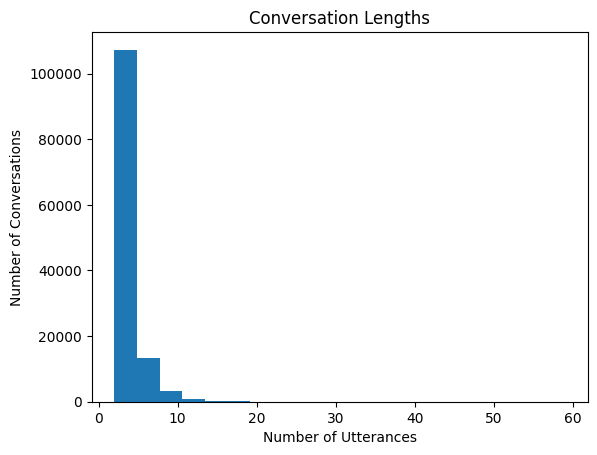

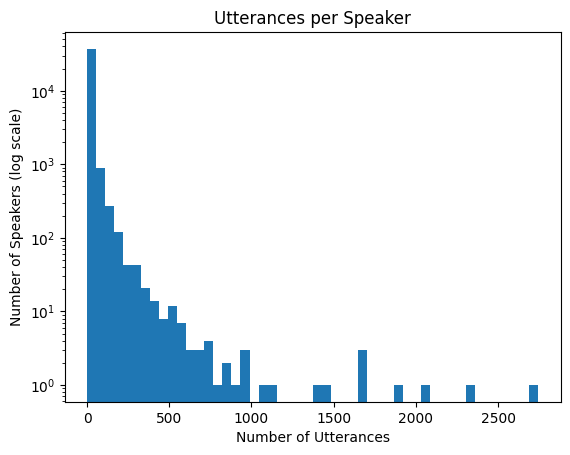

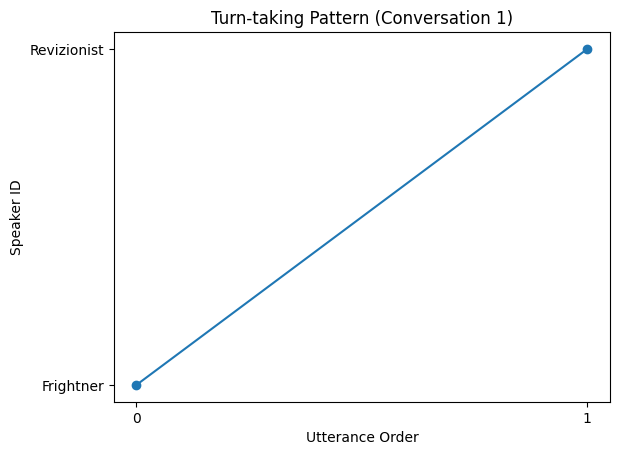

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# 1. Conversation lengths histogram
lengths = [len(list(convo.iter_utterances())) for convo in corpus.iter_conversations()]
plt.hist(lengths, bins=20)
plt.title("Conversation Lengths")
plt.xlabel("Number of Utterances")
plt.ylabel("Number of Conversations")
plt.show()

# 2. Utterances per speaker histogram
utterance_counts = Counter()
for convo in corpus.iter_conversations():
    for utt in convo.iter_utterances():
        utterance_counts[utt.speaker.id] += 1

counts = list(utterance_counts.values())
plt.hist(counts, bins=50, log=True)  # Log scale for skewed distribution
plt.title("Utterances per Speaker")
plt.xlabel("Number of Utterances")
plt.ylabel("Number of Speakers (log scale)")
plt.show()

# 3. Turn-taking pattern for first conversation
convo = next(corpus.iter_conversations())
speakers = [utt.speaker.id for utt in convo.iter_utterances()]
utterance_indices = list(range(len(speakers)))

plt.plot(utterance_indices, speakers, marker='o', linestyle='-')
plt.title("Turn-taking Pattern (Conversation 1)")
plt.xlabel("Utterance Order")
plt.ylabel("Speaker ID")
plt.xticks(utterance_indices)
plt.show()

#### Concept Recap: K-lines and D-traces

> K-lines (Epistemic Memory Paths):
These are horizontal trajectories across the time dimension I for a fixed perspective m and deliberation round j.
They represent how the state of a particular perspective evolves over the sequence of utterances in a single conversation.

> D-traces (Deliberative Traces):
These are vertical flows across deliberation rounds J at a fixed time i and perspective m.
They represent how the state at a particular point in the conversation evolves or propagates across different deliberations (conversations).

In [5]:
import numpy as np

# Assume X is your tensor of shape (M, I, J)

def get_k_line(X, m, j):
    # Extract horizontal K-line for perspective m, round j
    return X[m, :, j]  # shape: (I,)

def get_d_trace(X, m, i):
    # Extract vertical D-trace for perspective m, time i
    return X[m, i, :]  # shape: (J,)

In [8]:
# initialise tensor X

import numpy as np
M = 768
I = 50
J = 100
X = np.zeros((M, I, J))

print(f"Tensor X initialized with shape: {X.shape}")
print(f"First K-line (m=0, j=0): {get_k_line(X, 0, 0)[:5]}")
print(f"First D-trace (m=0, i=0): {get_d_trace(X, 0, 0)[:5]}")

Tensor X initialized with shape: (768, 50, 100)
First K-line (m=0, j=0): [0. 0. 0. 0. 0.]
First D-trace (m=0, i=0): [0. 0. 0. 0. 0.]


##### Tensors 

$$
\begin{align}
\textbf{Tensor Shape:} \quad X \in \mathbb{R}^{M \times I \times J} \\
\text{where:} \\
\quad M = 768 \quad \text{(embedding dimension)} \\
\quad I = 50 \quad \text{(utterances per conversation)} \\
\quad J = 100 \quad \text{(number of conversations)} \\

\textbf{K\text{-}line:} \quad \mathbf{k}_{m,j} = X[m, :, j] \in \mathbb{R}^{I} \\
\textbf{D\text{-}trace:} \quad \mathbf{d}_{m,i} = X[m, i, :] \in \mathbb{R}^{J}
\end{align}
$$

In [9]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
model.eval()

def get_gpt2_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state.squeeze(0)
    embedding = last_hidden.mean(dim=0).numpy()
    return embedding

# Try on a single utterance
sample_text = "This is a test sentence from the corpus."
embedding = get_gpt2_embedding(sample_text)
print("Embedding shape:", embedding.shape)
print("Sum of embedding:", embedding.sum())
print("First 5 values:", embedding[:5])

Embedding shape: (768,)
Sum of embedding: 279.33807
First 5 values: [ 0.00512126  0.03949732 -0.4280011  -0.02284785  0.06329466]


In [10]:
from transformers import GPT2Tokenizer, GPT2Model
import torch
import numpy as np

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
model.eval()

def get_gpt2_embedding(text):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    # Last hidden state: (batch_size, sequence_length, hidden_size)
    last_hidden = outputs.last_hidden_state.squeeze(0)  # shape: (seq_len, hidden_size)
    # Mean pooling over tokens
    embedding = last_hidden.mean(dim=0).numpy()  # shape: (hidden_size,)
    return embedding

# Example usage
text = "This is a sample utterance."
embedding = get_gpt2_embedding(text)
print(embedding.shape)  # (768,) for GPT-2 base

(768,)


In [12]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2Model.from_pretrained('gpt2')
model.eval()

def get_gpt2_embedding(text):
    if not text.strip():
        # Return zero vector if text is empty or only whitespace
        return np.zeros(768, dtype=np.float32)
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    if inputs['input_ids'].shape[1] == 0:
        # Return zero vector if tokenized input is empty
        return np.zeros(768, dtype=np.float32)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden = outputs.last_hidden_state.squeeze(0)
    if last_hidden.shape[0] == 0:
        return np.zeros(768, dtype=np.float32)
    embedding = last_hidden.mean(dim=0).numpy()
    return embedding

for j, convo in enumerate(corpus.iter_conversations()):
    if j >= J:
        break
    print(f"Processing conversation {j}")
    for i, utt in enumerate(convo.iter_utterances()):
        if i >= I:
            break
        print(f"  Utterance {i}: {utt.text[:50]}...")  # Truncated for readability
        emb = get_gpt2_embedding(utt.text)
        X[:, i, j] = emb

Processing conversation 0
  Utterance 0: You should look at all of the point on the templat...
  Utterance 1: Yes I agree. The law permits usage of documents, p...
Processing conversation 1
  Utterance 0: Yes, that's good. Revathy's page looked very relia...
  Utterance 1: Nagma'a site, at least that filmography page, look...
  Utterance 2: I don't think there are many such official reliabl...
  Utterance 3: Most of the so called \"official sites\" are maint...
Processing conversation 2
  Utterance 0: You closed [[Wikipedia:Articles for deletion\/J. K...
  Utterance 1: Well, notability cannot be acquired in 4 days. Tha...
  Utterance 2: No, no, I was the nominator! Just wanted to make s...
  Utterance 3: I was a bit surprised because i know you were the ...
Processing conversation 3
  Utterance 0: Hello Dana, thanks for contribute in this [[Templa...
  Utterance 1: My apologies, I forgot to include the disambiguato...
Processing conversation 4
  Utterance 0: Hey, who said so? Frankly, 

In [ ]:
print("Tensor shape:", X.shape)
print("Total sum of values in tensor:", np.sum(X))
print("Nonzero elements:", np.count_nonzero(X))
print("Mean value in tensor:", np.mean(X))
# embeddings print get_gpt2_embedding(utt.text)  



Tensor shape: (768, 50, 100)
Total sum of values in tensor: 99714.48887525254
Nonzero elements: 257280
Mean value in tensor: 0.025967314811263683


### Plots 

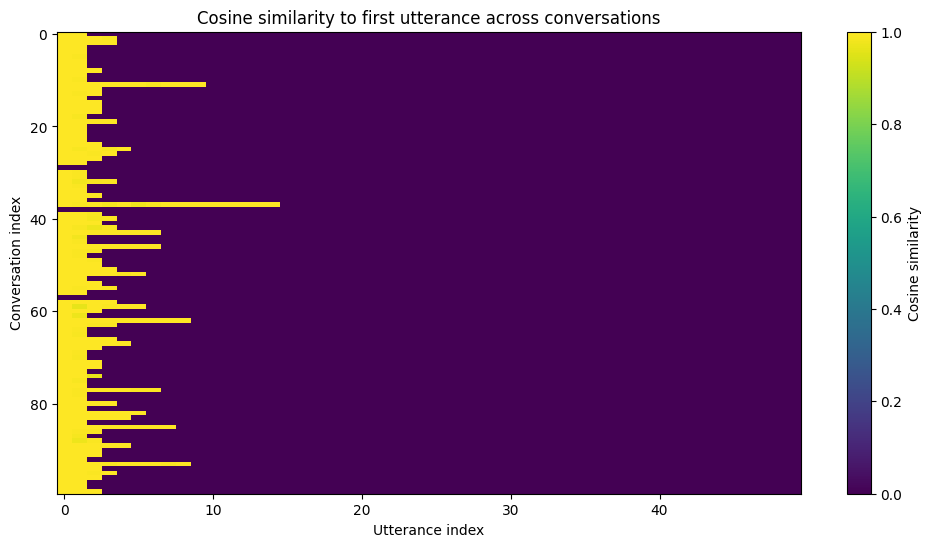

In [201]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

# X shape: (768, I, J)
I = X.shape[1]  # Number of utterances
J = X.shape[2]  # Number of conversations

similarity_matrix = np.zeros((J, I))  # Each row: cosine sims over utterances for a conversation

for j in range(J):
    convo_matrix = X[:, :, j].T  # Shape: (I, 768) — utterance embeddings
    sim = cosine_similarity(convo_matrix[0:1], convo_matrix)[0]  # Compare all to first
    similarity_matrix[j, :] = sim

# Plot as heatmap (each row = conversation, each column = utterance)
plt.figure(figsize=(12, 6))
plt.imshow(similarity_matrix, aspect='auto', cmap='viridis', interpolation='nearest')
plt.title("Cosine similarity to first utterance across conversations")
plt.xlabel("Utterance index")
plt.ylabel("Conversation index")
plt.colorbar(label="Cosine similarity")
plt.show()

/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/2619085659.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Dimension", y="Value", data=df_melted, inner="point", scale="width", cut=0)


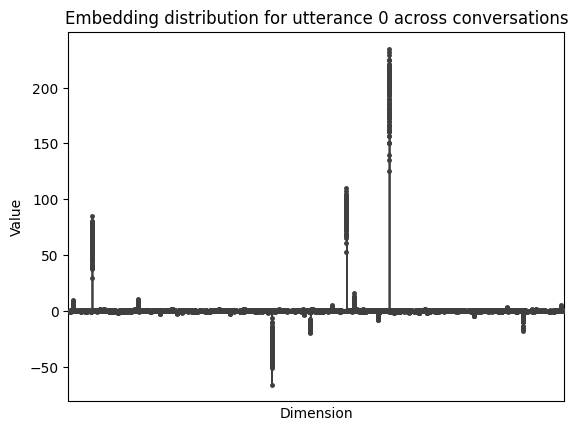

In [202]:
# Seaborn

import seaborn as sns
import pandas as pd

# Example: visualizing spread across a single utterance across all conversations
i = 0  # utterance index
data = X[:, i, :]  # shape: (768, J)
df = pd.DataFrame(data.T)  # shape: (J, 768)

# Melt for seaborn
df_melted = df.melt(var_name='Dimension', value_name='Value')
sns.violinplot(x="Dimension", y="Value", data=df_melted, inner="point", scale="width", cut=0)
plt.title(f"Embedding distribution for utterance {i} across conversations")
plt.xticks([], [])  # Hide x-ticks due to crowding
plt.show()

Visualizing 1000 utterances × 768 dimensions = 768000 points
Computing cosine similarity matrix...
Recurrence score range after clipping: 0–329


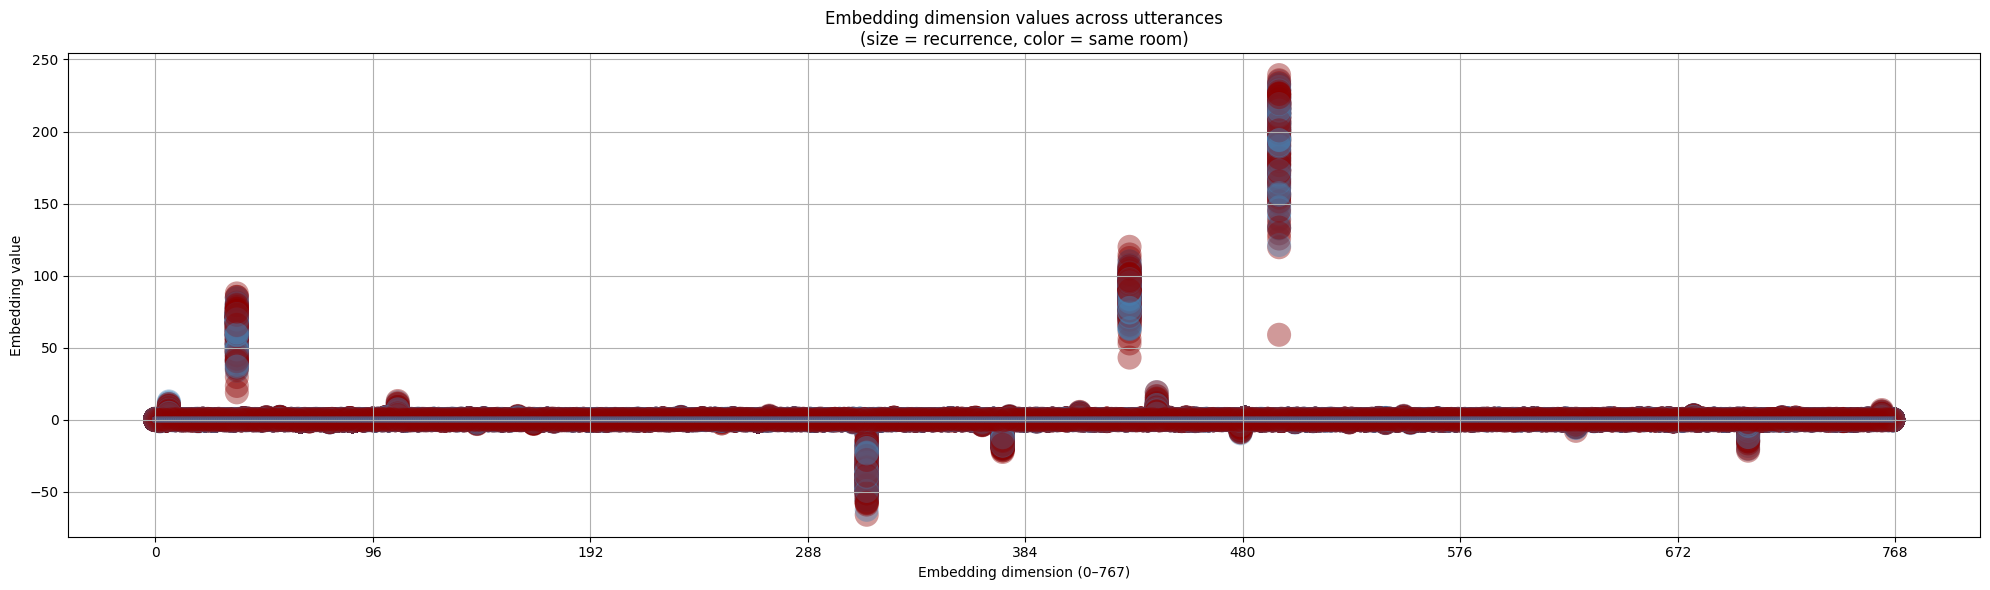

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Assume X is your embedding tensor of shape (768, I, J)
M, I, J = X.shape
i_range = range(10)  # number of utterances to visualize
utterance_count = len(i_range) * J

print(f"Visualizing {utterance_count} utterances × {M} dimensions = {utterance_count * M} points")

# Step 1: Extract embeddings for selected utterances across conversations
data = X[:, i_range, :].reshape(M, -1)  # shape: (768, N)
utterance_embeddings = data.T  # (N, 768)

# Step 1a: Clean embeddings to avoid invalid values
if not np.all(np.isfinite(utterance_embeddings)):
    print("Sanitizing embedding data: replacing NaN/Inf with finite values")
    utterance_embeddings = np.nan_to_num(utterance_embeddings, nan=0.0, posinf=1e5, neginf=-1e5)
    utterance_embeddings = np.clip(utterance_embeddings, -1e3, 1e3)

val = utterance_embeddings.flatten()
dim = np.tile(np.arange(M), utterance_count)

# Step 2: Compute cosine similarity recurrence
print("Computing cosine similarity matrix...")
similarity_matrix = cosine_similarity(utterance_embeddings)

if not np.all(np.isfinite(similarity_matrix)):
    raise ValueError("Similarity matrix contains invalid values")

threshold = 0.5
recurrence_scores = (similarity_matrix > threshold).sum(axis=1) - 1  # subtract self-match

# Clip negatives to zero to avoid invalid log input
recurrence_scores = np.maximum(recurrence_scores, 0)

print(f"Recurrence score range after clipping: {recurrence_scores.min()}–{recurrence_scores.max()}")

recurrence_log = np.log1p(recurrence_scores)

# Log scale recurrence for better size distribution
recurrence_scores = (similarity_matrix > threshold).sum(axis=1) - 1

# Normalize to a point size scale (points²) 
noise = np.random.uniform(0, 1, size=recurrence_scores.shape) * 0.1
recurrence_noisy = recurrence_scores + noise
# radius_scaled = scaler.fit_transform(recurrence_log.reshape(-1, 1)).flatten()
scaler = MinMaxScaler(feature_range=(20, 300))
radius_scaled = scaler.fit_transform(recurrence_noisy.reshape(-1, 1)).flatten()
size = np.repeat(radius_scaled, M)

# Step 3: Generate or load your "same room" mask of shape (N,)
# Replace with actual data; here random placeholder
same_room_mask = np.random.choice([True, False], size=utterance_count, p=[0.5, 0.5])
color_map = ['steelblue' if is_same else 'darkred' for is_same in same_room_mask]
color = np.repeat(color_map, M)

# Step 4: Plotting
plt.figure(figsize=(20, 6))
plt.scatter(dim, val, s=size, c=color, alpha=0.4, linewidth=0)
plt.title("Embedding dimension values across utterances\n(size = recurrence, color = same room)")
plt.xlabel("Embedding dimension (0–767)")
plt.ylabel("Embedding value")
plt.xticks(np.linspace(0, M, 9))
plt.grid(True)
plt.tight_layout()
plt.show()

radius 

In [209]:
print("Radius stats:")
print(f" min: {radius_scaled.min():.2f}, max: {radius_scaled.max():.2f}")
print(f" mean: {radius_scaled.mean():.2f}, std: {radius_scaled.std():.2f}")
print(f" unique values count: {len(np.unique(radius_scaled))}")

unique_vals, counts = np.unique(recurrence_log, return_counts=True)
print("Recurrence log unique values and counts:")
for val, count in zip(unique_vals, counts):
    print(f"Value: {val:.3f}, Count: {count}")

Radius stats:
 min: 20.00, max: 300.00
 mean: 112.40, std: 131.66
 unique values count: 2
Recurrence log unique values and counts:
Value: 0.000, Count: 670
Value: 5.799, Count: 330


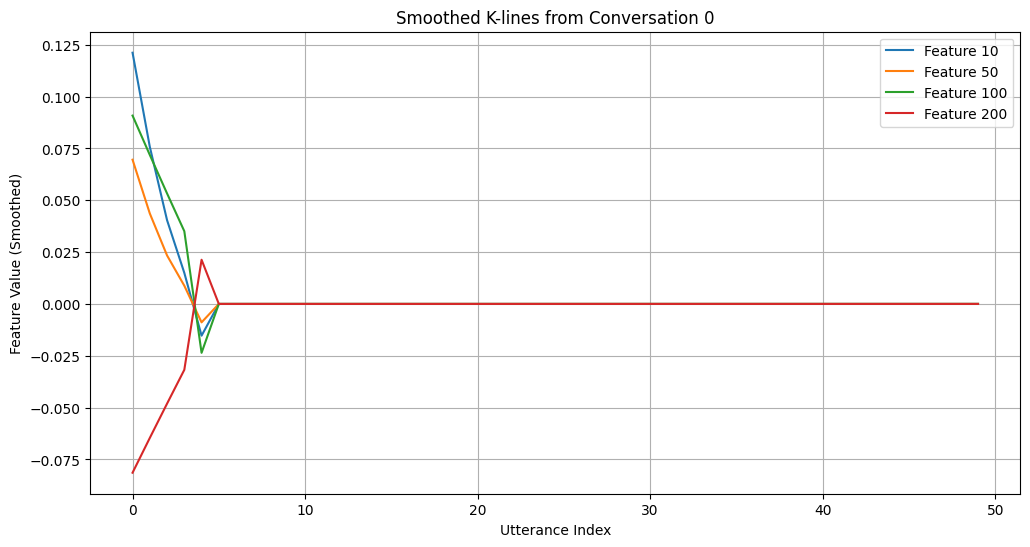

In [19]:
import numpy as np

def smooth_series(series, window=5):
    return np.convolve(series, np.ones(window)/window, mode='same')
from scipy.signal import savgol_filter

def smooth_savgol(series, window=7, poly=2):
    return savgol_filter(series, window_length=window, polyorder=poly)

plt.figure(figsize=(12, 6))

for m in [10, 50, 100, 200]:  # multiple features
    raw = X[m, :, 0]
    smoothed = smooth_savgol(raw)
    plt.plot(smoothed, label=f"Feature {m}")

plt.title("Smoothed K-lines from Conversation 0")
plt.xlabel("Utterance Index")
plt.ylabel("Feature Value (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

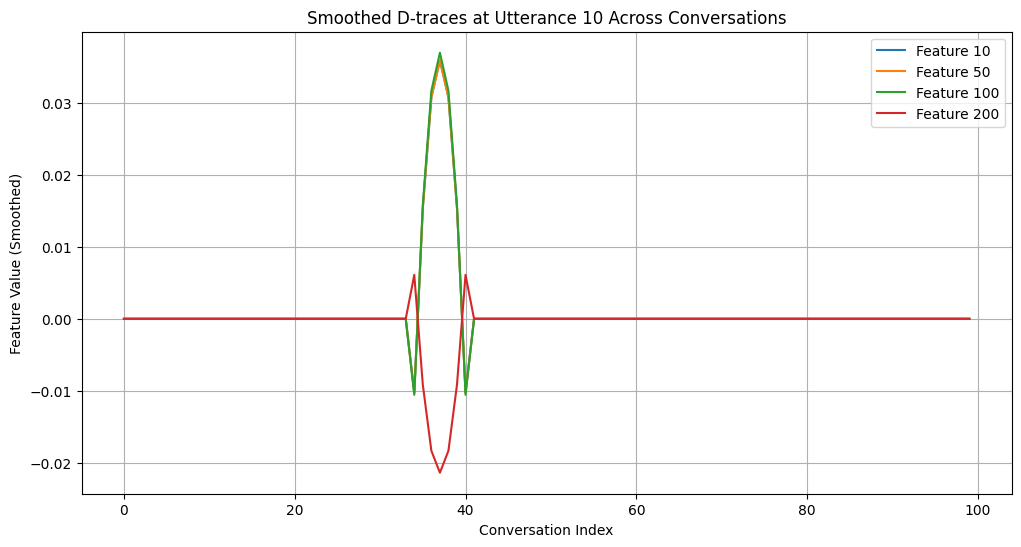

In [20]:
plt.figure(figsize=(12, 6))

for m in [10, 50, 100, 200]:  # multiple features
    raw = X[m, 10, :]  # utterance 10 across conversations
    smoothed = smooth_savgol(raw)
    plt.plot(smoothed, label=f"Feature {m}")

plt.title("Smoothed D-traces at Utterance 10 Across Conversations")
plt.xlabel("Conversation Index")
plt.ylabel("Feature Value (Smoothed)")
plt.legend()
plt.grid(True)
plt.show()

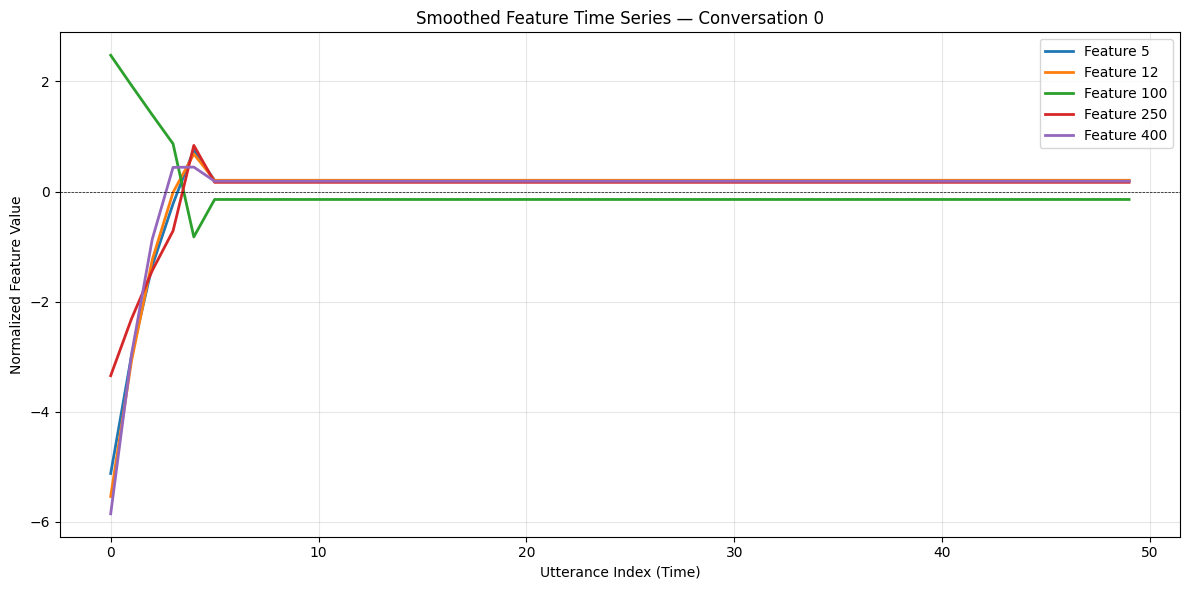

In [197]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import numpy as np

# Parameters
conv_id = 0         # conversation index
feature_ids = [5, 12, 100, 250, 400]  # chosen semantic features (arbitrary or based on variance)
window = 7           # smoothing window (odd number)
poly = 2         # smoothing polynomial degree

# Setup plot
plt.figure(figsize=(12, 6))

for m in feature_ids:
    raw = X[m, :, conv_id]                     # shape: (50,)
    if np.all(raw == 0): continue              # skip empty
    z = (raw - np.mean(raw)) / (np.std(raw) + 1e-8)  # normalize
    smoothed = savgol_filter(z, window, poly)
    plt.plot(smoothed, label=f"Feature {m}", linewidth=2)

# Styling
plt.title(f"Smoothed Feature Time Series — Conversation {conv_id}")
plt.xlabel("Utterance Index (Time)")
plt.ylabel("Normalized Feature Value")
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

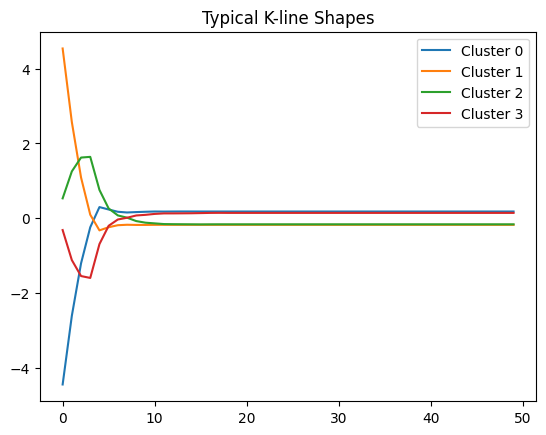

In [45]:
from sklearn.cluster import KMeans

# Create matrix: each row is a K-line from one feature in one conversation
data = [X[m, :, j] for j in range(J) for m in range(0, M, 20)]
data = np.array([savgol_filter((d - np.mean(d)) / (np.std(d) + 1e-8), 7, 2) for d in data])

kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(data)

# Visualize the centroids
for i in range(4):
    plt.plot(kmeans.cluster_centers_[i], label=f"Cluster {i}")
plt.title("Typical K-line Shapes")
plt.legend()
plt.show()

/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/52366602.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t, i, s=30, c=plt.cm.viridis((values[t]+3)/6), edgecolor='k')


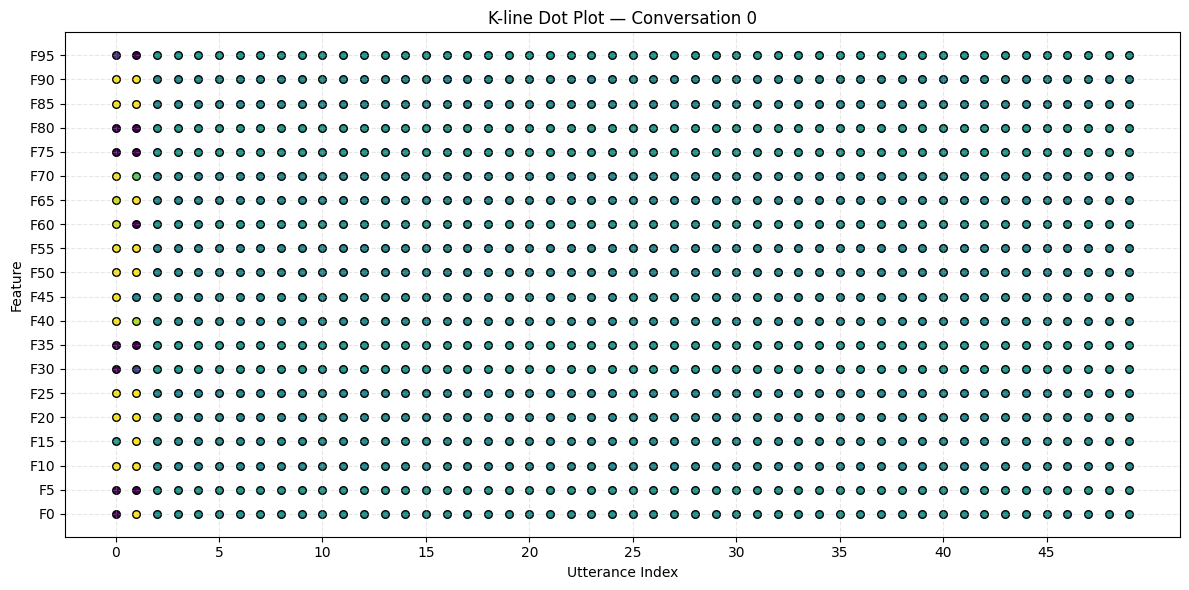

In [46]:
import matplotlib.pyplot as plt
import numpy as np

conv_id = 0
features = list(range(0, 100, 5))  # 20 features for visibility
T = X.shape[1]  # number of utterances

fig, ax = plt.subplots(figsize=(12, 6))

for i, m in enumerate(features):
    values = X[m, :, conv_id]
    values = (values - np.mean(values)) / (np.std(values) + 1e-8)  # normalize
    for t in range(T):
        ax.scatter(t, i, s=30, c=plt.cm.viridis((values[t]+3)/6), edgecolor='k')

ax.set_yticks(range(len(features)))
ax.set_yticklabels([f"F{m}" for m in features])
ax.set_xticks(range(0, T, 5))
ax.set_xlabel("Utterance Index")
ax.set_ylabel("Feature")
ax.set_title(f"K-line Dot Plot — Conversation {conv_id}")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/2595317126.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(i, j, s=30, c=plt.cm.plasma((value+3)/6), edgecolor='k')


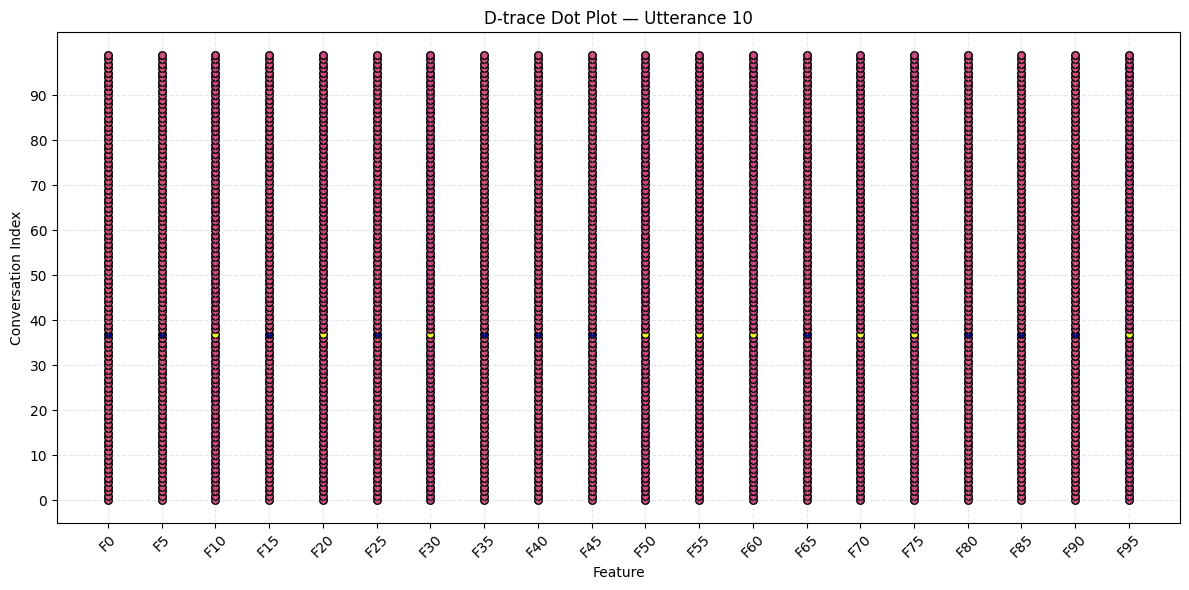

In [47]:
time_index = 10  # fixed utterance index
features = list(range(0, 100, 5))
J = X.shape[2]  # number of conversations

fig, ax = plt.subplots(figsize=(12, 6))

for j in range(J):
    for i, m in enumerate(features):
        value = X[m, time_index, j]
        value = (value - np.mean(X[m, time_index, :])) / (np.std(X[m, time_index, :]) + 1e-8)
        ax.scatter(i, j, s=30, c=plt.cm.plasma((value+3)/6), edgecolor='k')

ax.set_xticks(range(len(features)))
ax.set_xticklabels([f"F{m}" for m in features], rotation=45)
ax.set_yticks(range(0, J, 10))
ax.set_ylabel("Conversation Index")
ax.set_xlabel("Feature")
ax.set_title(f"D-trace Dot Plot — Utterance {time_index}")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Mutliple D-traces and K-lines 


/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/2477307429.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t, i, s=30, c=plt.cm.viridis((values[t]+3)/6), edgecolor='k')


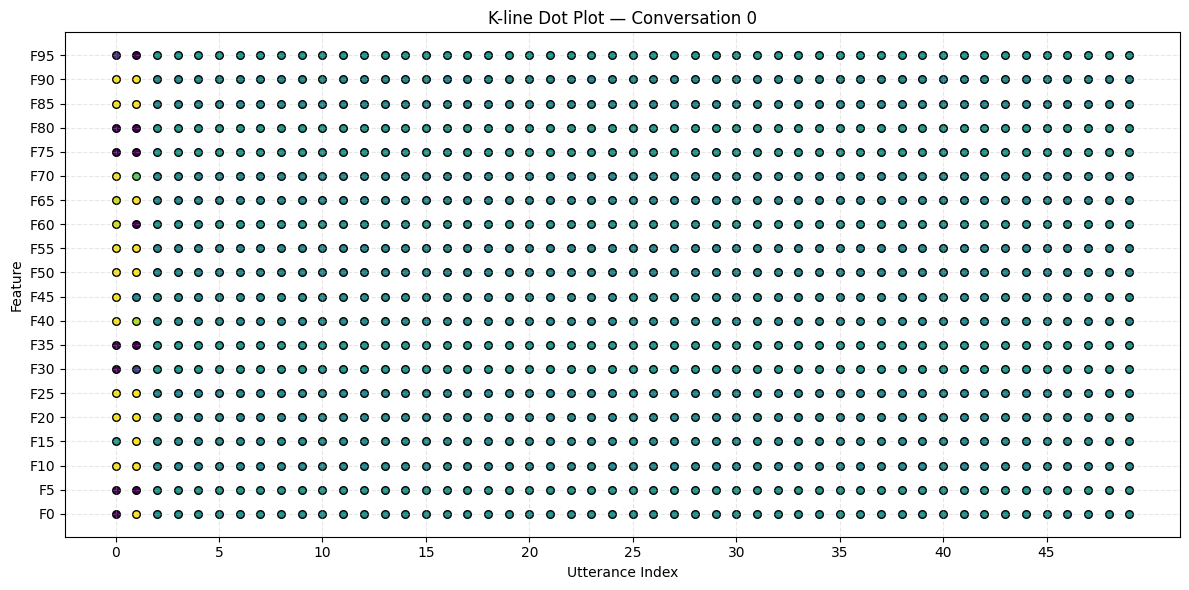

/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/2477307429.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t, i, s=30, c=plt.cm.viridis((values[t]+3)/6), edgecolor='k')


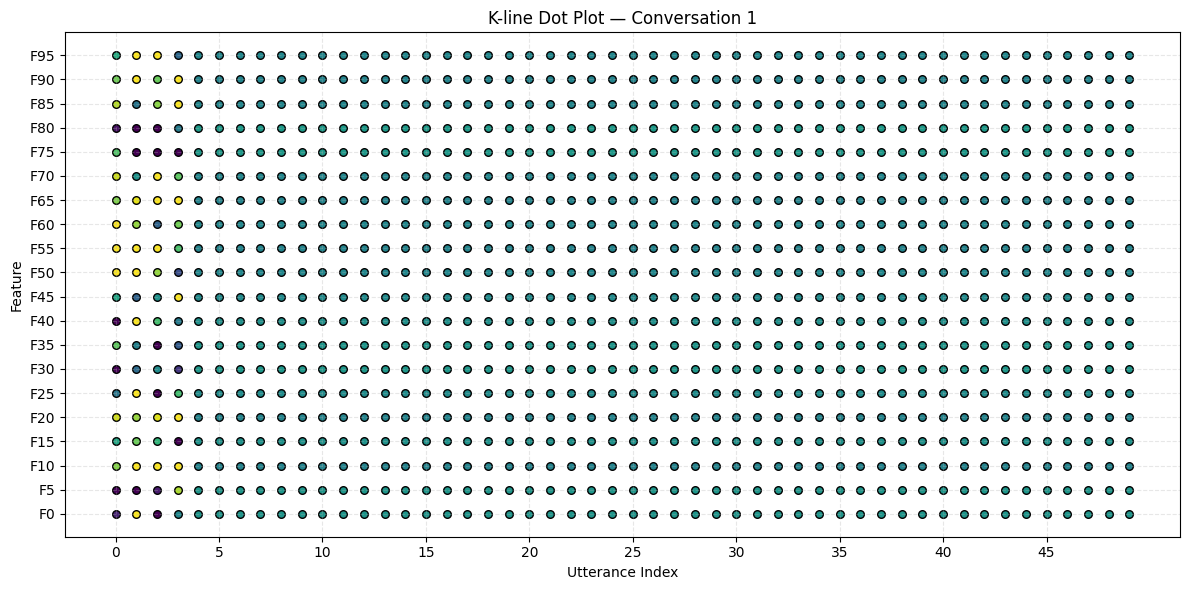

/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/2477307429.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t, i, s=30, c=plt.cm.viridis((values[t]+3)/6), edgecolor='k')


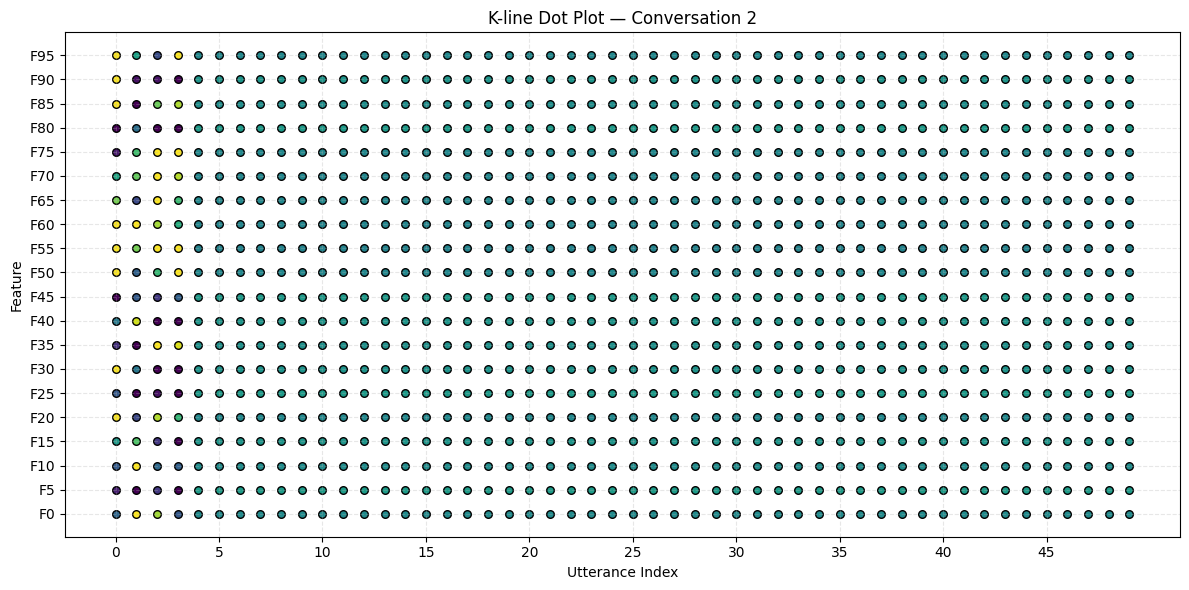

In [48]:
def plot_kline_dotplots(X, conv_ids, features=None):
    """
    Plot K-line dot plots for multiple conversations.

    Args:
        X: numpy array of shape (M, I, J)
        conv_ids: list of conversation indices to plot
        features: list of feature indices (default: range(0, 100, 5))
    """
    if features is None:
        features = list(range(0, 100, 5))
    T = X.shape[1]
    for conv_id in conv_ids:
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, m in enumerate(features):
            values = X[m, :, conv_id]
            values = (values - np.mean(values)) / (np.std(values) + 1e-8)
            for t in range(T):
                ax.scatter(t, i, s=30, c=plt.cm.viridis((values[t]+3)/6), edgecolor='k')
        ax.set_yticks(range(len(features)))
        ax.set_yticklabels([f"F{m}" for m in features])
        ax.set_xticks(range(0, T, 5))
        ax.set_xlabel("Utterance Index")
        ax.set_ylabel("Feature")
        ax.set_title(f"K-line Dot Plot — Conversation {conv_id}")
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

# Example usage:
plot_kline_dotplots(X, conv_ids=[0, 1, 2])

Stacked Plots


In [49]:
import matplotlib.pyplot as plt

def stacked_kline_dotplots(X, conv_ids, features=None):
    if features is None:
        features = list(range(0, 100, 10))  # reduce for clarity
    T = X.shape[1]
    num_convs = len(conv_ids)

    fig, axes = plt.subplots(num_convs, 1, figsize=(12, 1.5 * num_convs), sharex=True)

    if num_convs == 1:
        axes = [axes]  # handle single plot case

    for idx, conv_id in enumerate(conv_ids):
        ax = axes[idx]
        for i, m in enumerate(features):
            values = X[m, :, conv_id]
            values = (values - np.mean(values)) / (np.std(values) + 1e-8)
            for t in range(T):
                ax.scatter(t, i, s=10, c=plt.cm.viridis((values[t]+3)/6), edgecolor='none')
        ax.set_yticks(range(len(features)))
        ax.set_yticklabels([f"F{m}" for m in features], fontsize=6)
        ax.set_ylabel(f"Conv {conv_id}", fontsize=8)
        ax.grid(True, linestyle='--', alpha=0.2)

    axes[-1].set_xlabel("Utterance Index")
    fig.suptitle("Stacked K-line Dot Plots for Conversations", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/799490034.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t, i, s=10, c=plt.cm.viridis((values[t]+3)/6), edgecolor='none')
/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/799490034.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t, i, s=10, c=plt.cm.viridis((values[t]+3)/6), edgecolor='none')
/var/folders/sj/0q3_

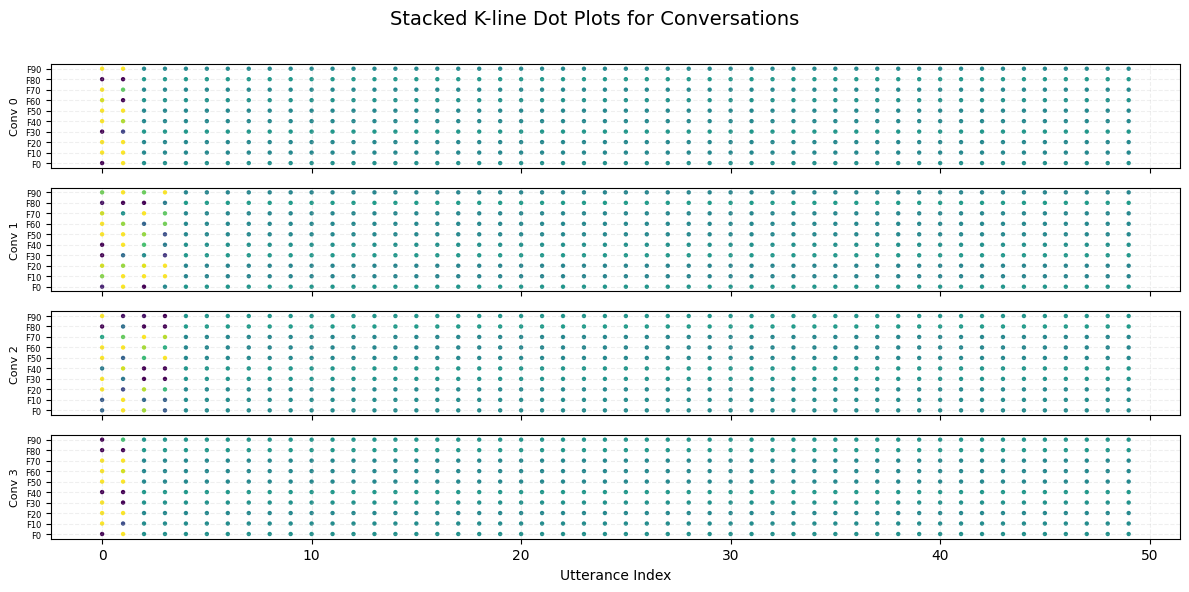

In [52]:
stacked_kline_dotplots(X, conv_ids=list(range(4)))

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def unified_kline_dotplot(X, conv_ids, features=None):
    if features is None:
        features = list(range(0, 100, 10))  # fewer for clarity
    T = X.shape[1]
    N = len(conv_ids)
    F = len(features)

    # Stack all blocks horizontally: each block is (F, T) for a conversation
    blocks = []
    for conv_id in conv_ids:
        block = np.array([
            (X[m, :, conv_id] - np.mean(X[m, :, conv_id])) / (np.std(X[m, :, conv_id]) + 1e-8)
            for m in features
        ])
        blocks.append(block)
    data = np.hstack(blocks)  # shape: (F, N*T)

    fig, ax = plt.subplots(figsize=(14, 0.2 * F + 2))
    for fi in range(F):
        for t in range(data.shape[1]):
            ax.scatter(t, fi, s=20, c=plt.cm.viridis((data[fi, t]+3)/2), edgecolor='none')

    # Axes formatting
    xticks = []
    xlabels = []
    offset = 0
    for i, conv_id in enumerate(conv_ids):
        xticks.append(offset + T // 2)
        xlabels.append(f"C{conv_id}")
        offset += T

    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_yticks(range(F))
    ax.set_yticklabels([f"F{m}" for m in features])
    ax.set_xlabel("Utterance Index (stacked by conversation)")
    ax.set_ylabel("Feature")
    ax.set_title("Unified K-line Dot Plot (Stacked Conversations)")
    ax.grid(True, linestyle='--', alpha=0.2)
    plt.tight_layout()
    plt.show()

/var/folders/sj/0q3_0t_954lfg89yl9zsv3t40000gn/T/ipykernel_44690/2365678546.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t, fi, s=20, c=plt.cm.viridis((data[fi, t]+3)/2), edgecolor='none')


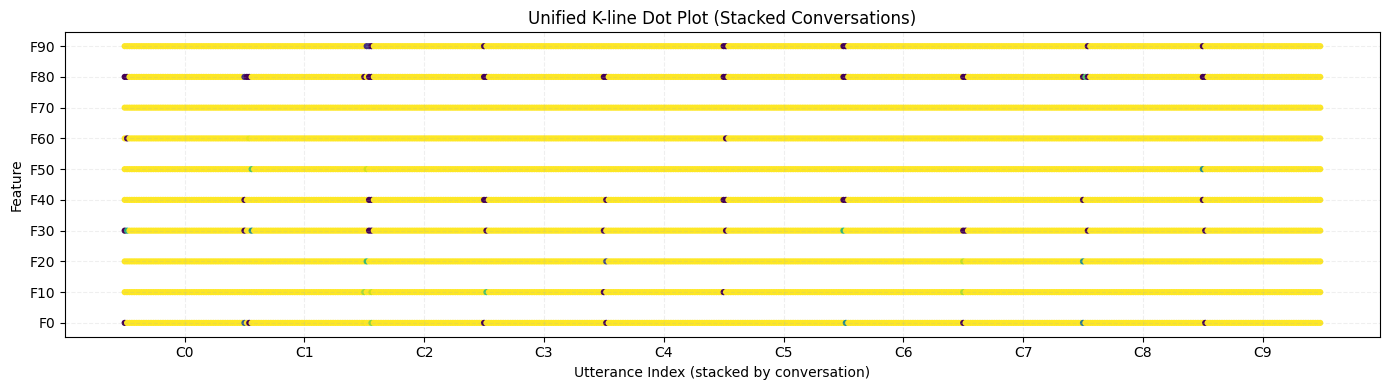

In [77]:
unified_kline_dotplot(X, conv_ids=list(range(10)))

A map of conversations based on what concepts (features) they emphasize.


In [80]:
# Average feature activation over time per conversation
# Result shape: (J, M)
conversation_feature_means = np.mean(X, axis=1).T  # shape: (J, M)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Z = scaler.fit_transform(conversation_feature_means)  # shape: (J, M)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=42)
Z_2d = tsne.fit_transform(Z)  # shape: (J, 2)



Why This Matters

The t-SNE plot of “which concepts are emphasized by whom” is not derivable from the raw dataset alone. You only get this by:

- Embedding each utterance into a meaning space (via GPT-2)

- Organizing those embeddings temporally and across deliberations

- Projecting that structured semantic memory into interpretable maps



⸻

🏛️ Analogy

Without tensors → like having a transcript of 100 debates.
With tensors → like having cognitive maps of each debate: what was remembered, focused on, stressed, or ignored.

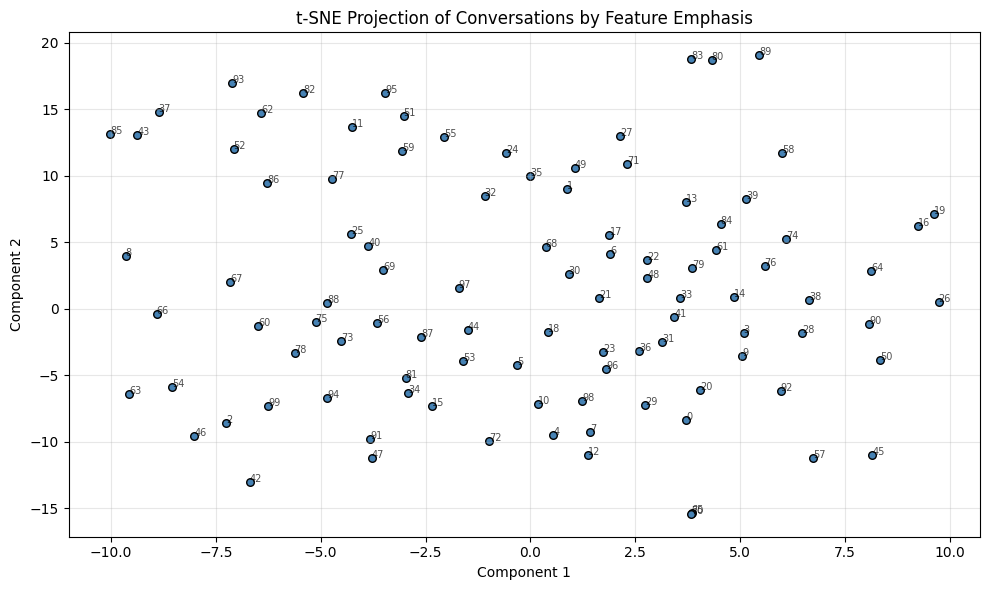

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c='steelblue', s=30, edgecolor='k')

for i in range(Z_2d.shape[0]):
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=7, alpha=0.7)

plt.title("t-SNE Projection of Conversations by Feature Emphasis")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

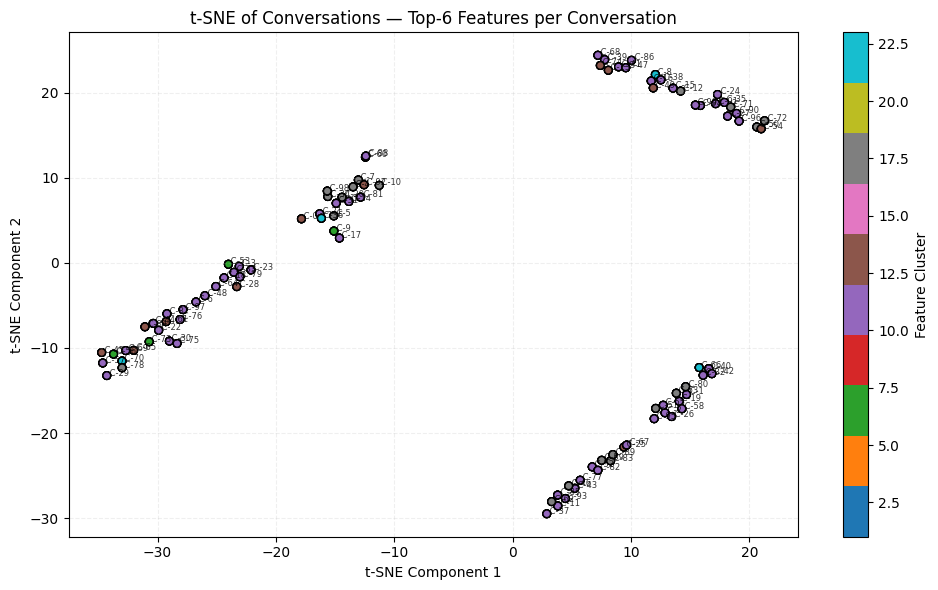

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Assume conversation_feature_means is your (num_conversations x num_features) matrix
# Step 1: Dimensionality reduction on features for clustering
feature_means = conversation_feature_means.T  # shape: (num_features, num_conversations)
reduced_features = PCA(n_components=30).fit_transform(feature_means)

# Step 2: Cluster features into semantic groups
n_feature_clusters = 24
kmeans_feat = KMeans(n_clusters=n_feature_clusters, random_state=0)
feature_labels = kmeans_feat.fit_predict(reduced_features)  # (num_features,)

# Step 3: Compute t-SNE embedding of conversations based on their feature activations
tsne = TSNE(n_components=2, random_state=24, perplexity=8)
Z_2d = tsne.fit_transform(conversation_feature_means)  # shape: (num_conversations, 2)

# Step 4: Get top-k features per conversation
top_k = 6
topk_feature_indices = np.argsort(-conversation_feature_means, axis=1)[:, :top_k]  # (num_conversations, top_k)
topk_feature_clusters = np.array([[feature_labels[f] for f in feats] for feats in topk_feature_indices])

# Step 5: Flatten data for plotting
Z_multi = np.repeat(Z_2d, top_k, axis=0)  # (num_conversations * top_k, 2)
clusters_multi = topk_feature_clusters.flatten()
features_multi = topk_feature_indices.flatten()

# Step 6: Plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    Z_multi[:, 0], Z_multi[:, 1],
    c=clusters_multi,
    cmap='tab10',
    s=30,
    edgecolors='k',
    alpha=1.0
)
plt.colorbar(scatter, label="Feature Cluster")

num_conversations = conversation_feature_means.shape[0]
for i in range(num_conversations):
    x, y = Z_multi[i * top_k]
    feat = features_multi[i * top_k]
    plt.text(x, y, f" C-{i} ", fontsize=6, alpha=0.8)

plt.title(f"t-SNE of Conversations — Top-{top_k} Features per Conversation")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

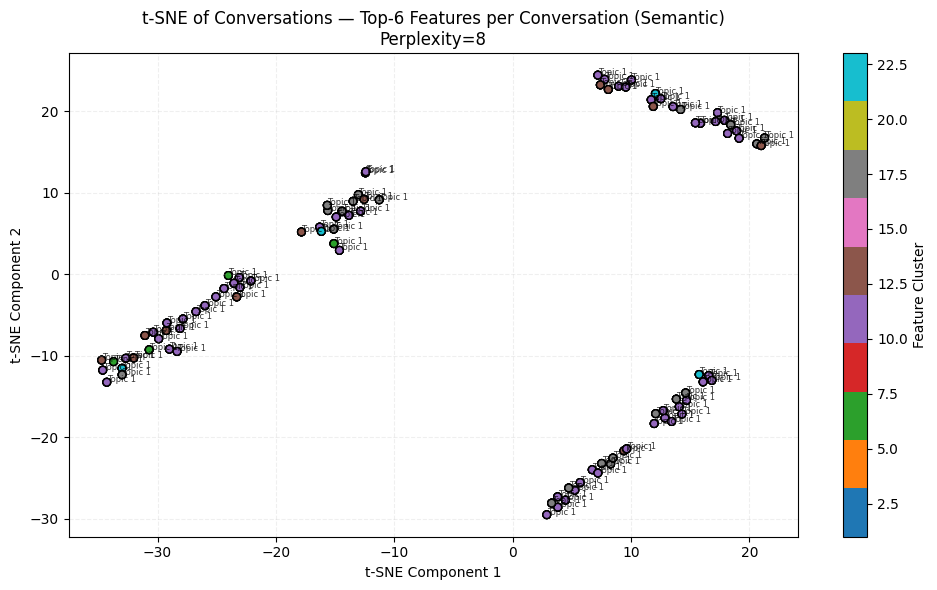

In [136]:
# Plotting D-traces for multiple features based on topic clusters

# Assuming feature_names dict exists mapping feature idx → string label
feature_names = {i: f"Topic {feature_labels[i]}" for i in range(len(feature_labels))}

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    Z_multi[:, 0], Z_multi[:, 1],
    c=clusters_multi,
    cmap='tab10',
    s=30,
    edgecolors='k',
    alpha=1.0
)
plt.colorbar(scatter, label="Feature Cluster")

num_conversations = conversation_feature_means.shape[0]
for i in range(num_conversations):
    x, y = Z_multi[i * top_k]
    semantic_label = feature_names[features_multi[i * top_k]]
    plt.text(x, y, f"{semantic_label}", fontsize=6, alpha=0.8)

plt.title(f"t-SNE of Conversations — Top-{top_k} Features per Conversation (Semantic)\nPerplexity={tsne.perplexity}")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

using GPT-2 for clusterin 


In [140]:
print(f"Tensor X initialized with shape: {embedding.shape}")

Tensor X initialized with shape: (768,)


In [142]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Step 1: Reshape the tensor to flatten utterances
M, I, J = X.shape
X_utterances = X.reshape(M, -1).T  # shape: (I * J, 768)

# Step 2: Cluster utterances using KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
utterance_cluster_labels = kmeans.fit_predict(X_utterances)



In [ ]:
print("Cluster labels for first 10 utterances: " + str(utterance_cluster_labels[:10])) 

Cluster labels for first 10 utterances: [ 4  4  1 15 18  9 17 11  9 12]


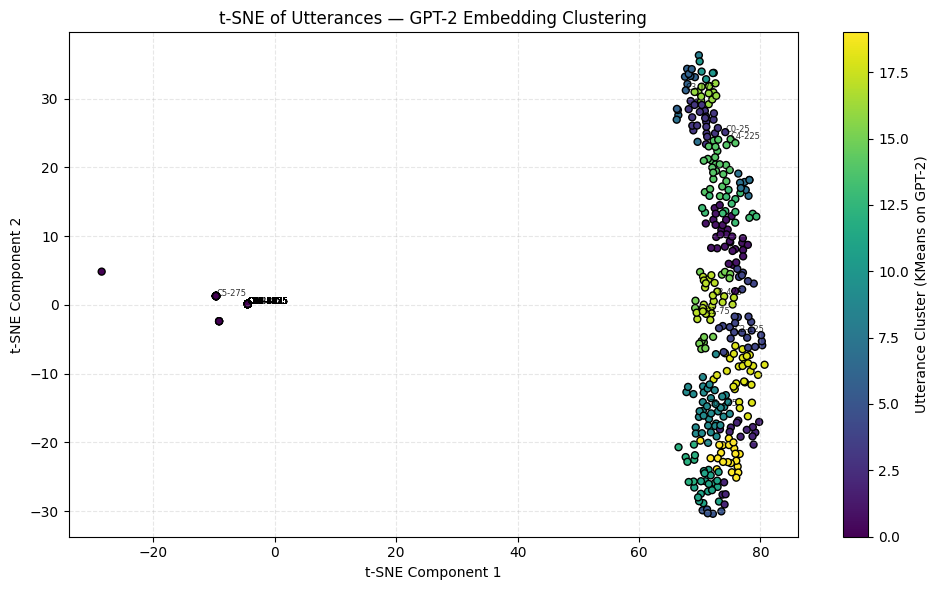

In [150]:
# Step 3: t-SNE projection
Z = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(X_utterances)

# Step 4: Plotting with viridis colormap
plt.figure(figsize=(10, 6))
scatter = plt.scatter(Z[:, 0], Z[:, 1],
                      c=utterance_cluster_labels,
                      cmap='viridis',
                      s=25,
                      edgecolor='k')

plt.colorbar(scatter, label="Utterance Cluster (KMeans on GPT-2)")

# Add conversation labels
I = X.shape[1]  # utterances per conversation
J = X.shape[2]  # number of conversations
for j in range(J):
    idx = j * I + I // 2  # middle utterance of conversation j
    plt.text(Z[idx, 0], Z[idx, 1], f"C{j}-{idx}", fontsize=6, alpha=0.8)

plt.title("t-SNE of Utterances — GPT-2 Embedding Clustering")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [190]:
import numpy as np
from sklearn.metrics import pairwise_distances_argmin_min

def print_cluster_representatives(X_utterances, utterance_cluster_labels, n_samples=40):
    n_clusters = np.max(utterance_cluster_labels) + 1
    for cluster_id in range(n_clusters):
        print(f"\nCluster {cluster_id} representative utterances:")
        cluster_indices = np.where(utterance_cluster_labels == cluster_id)[0]
        if len(cluster_indices) == 0:
            continue
        centroid = X_utterances[cluster_indices].mean(axis=0, keepdims=True)
        closest, _ = pairwise_distances_argmin_min(centroid, X_utterances[cluster_indices])
        closest_indices = cluster_indices[closest[:n_samples]]
        for idx in closest_indices:
            print(f" - {all_utterances[idx]}")


In [191]:
print_cluster_representatives(X_utterances, utterance_cluster_labels, n_samples=20)


Cluster 0 representative utterances:
 - Capricornis, stop insinuating. And please refrain from various [[Ad hominem]] arguments, as they are falacies. Comment on contributions please. 

Cluster 1 representative utterances:
 - Hi. Just writing that you closed out the [[WP:CFD]] as a '''merge and delete''', but category appears open still at this moment. Yours, 

Cluster 2 representative utterances:
 - At any rate, I didn't just make up a name haphazardly; \"Dove's Guide for Church Bell Ringers\" really does seem to be its current working title: [http:\/\/www.cccbr.org.uk\/dove\/home.php]. It hasn't been published in book form since 2000 and today's active form is the website; I think unless there's good reason otherwise a page's name and first sentence should refer to the ''current'' situation. In this case, doing so also considerably simplified things. Thanks, 

Cluster 3 representative utterances:
 - You guys are much too good to me! I hope after this experience kills me you guys wil


Cluster Topic Labels:
Cluster 0: Topic 1
Cluster 1: Topic 1
Cluster 2: Topic 1
Cluster 3: Topic 1
Cluster 4: Topic 1
Cluster 5: Topic 1


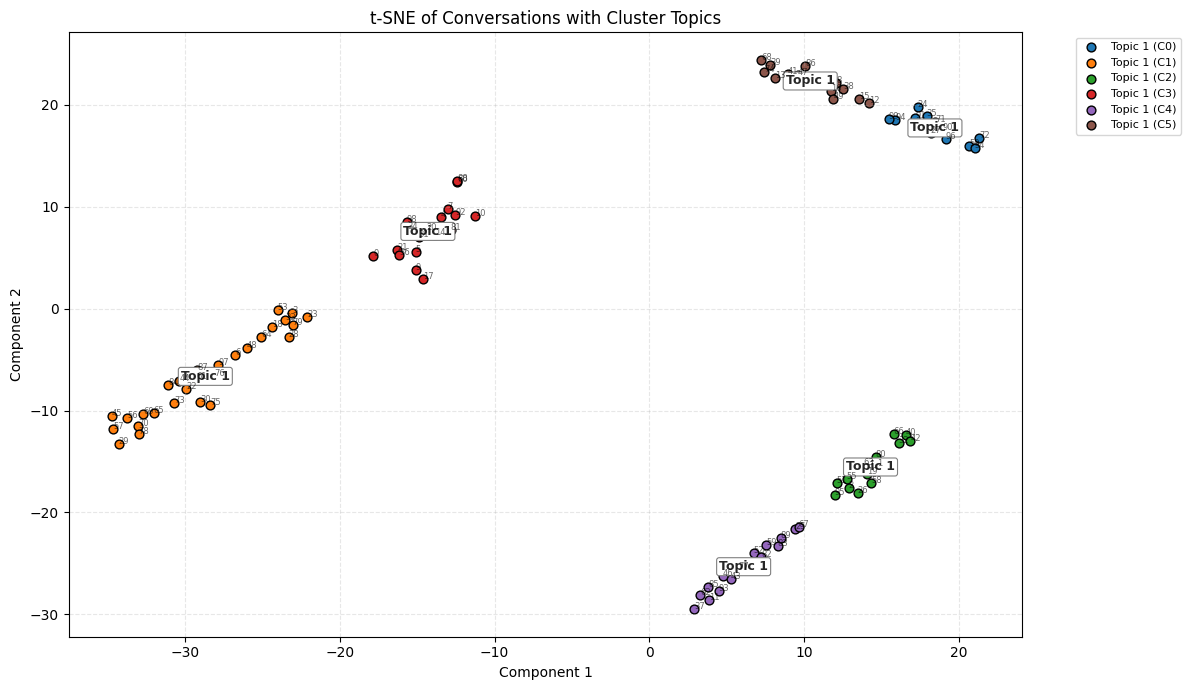

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Compute number of t-SNE clusters
n_tsne_clusters = np.max(tsne_cluster_labels) + 1

# Use top-k features per conversation to assign a topic label to each cluster
top_k = topk_feature_indices.shape[1]
cluster_topic_labels = []

for c in range(n_tsne_clusters):
    indices = np.where(tsne_cluster_labels == c)[0]
    top_feats = topk_feature_indices[indices].flatten()
    topic_names_in_cluster = [feature_names.get(f, f"F{f}") for f in top_feats]
    
    if topic_names_in_cluster:
        label = Counter(topic_names_in_cluster).most_common(1)[0][0]
    else:
        label = f"Cluster {c}"
    
    cluster_topic_labels.append(label)

# Optional: Print all labels
print("\nCluster Topic Labels:")
for c, label in enumerate(cluster_topic_labels):
    print(f"Cluster {c}: {label}")

# Plot
plt.figure(figsize=(12, 7))
cmap = plt.get_cmap('tab10')
colors = [cmap(i % 10) for i in range(n_tsne_clusters)]

for c in range(n_tsne_clusters):
    idx = np.where(tsne_cluster_labels == c)[0]
    points = Z_2d[idx]

    # Plot points
    plt.scatter(points[:, 0], points[:, 1],
                s=40,
                color=colors[c],
                label=f"{cluster_topic_labels[c][:25]} (C{c})",
                edgecolor='k')

    # Add topic label at cluster centroid
    centroid_x, centroid_y = np.mean(points, axis=0)
    plt.text(centroid_x, centroid_y, cluster_topic_labels[c],
             fontsize=9, fontweight='bold', color='black', alpha=0.85,
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.8))

    # Optional: Label each point
    for i in idx:
        plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=6, alpha=0.6)

plt.title("t-SNE of Conversations with Cluster Topics")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Cluster centroids shape: (20, 768)


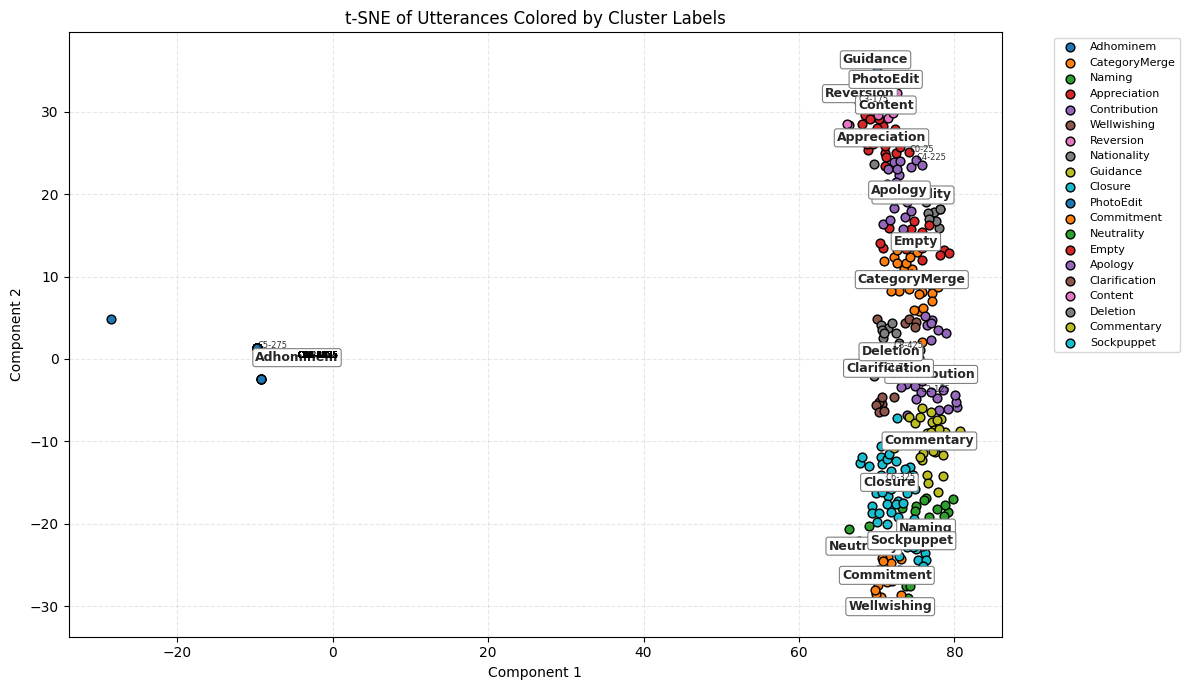

In [192]:
import numpy as np
import matplotlib.pyplot as plt

# Cluster labels mapped to their one-word names
cluster_names = {
    0: "Adhominem",
    1: "CategoryMerge",
    2: "Naming",
    3: "Appreciation",
    4: "Contribution",
    5: "Wellwishing",
    6: "Reversion",
    7: "Nationality",
    8: "Guidance",
    9: "Closure",
    10: "PhotoEdit",
    11: "Commitment",
    12: "Neutrality",
    13: "Empty",
    14: "Apology",
    15: "Clarification",
    16: "Content",
    17: "Deletion",
    18: "Commentary",
    19: "Sockpuppet",
}

n_clusters = np.max(utterance_cluster_labels) + 1

plt.figure(figsize=(12, 7))
cmap = plt.get_cmap('tab10')
colors = [cmap(i % 10) for i in range(n_clusters)]

for c in range(n_clusters):
    idx = np.where(utterance_cluster_labels == c)[0]
    points = Z[idx]  # Z is the t-SNE embedding for utterances
    
    plt.scatter(points[:, 0], points[:, 1],
                s=40,
                color=colors[c],
                label=cluster_names.get(c, f"Cluster {c}"),
                edgecolor='k')
    
    centroid_x, centroid_y = np.mean(points, axis=0)
    plt.text(centroid_x, centroid_y, cluster_names.get(c, f"C-{c}"),
             fontsize=9, fontweight='bold', color='black', alpha=0.85,
             ha='center', va='center',
             bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.8))
    # Add conversation labels
I = X.shape[1]  # utterances per conversation
J = X.shape[2]  # number of conversations
for j in range(J):
    idx = j * I + I // 2  # middle utterance of conversation j
    plt.text(Z[idx, 0], Z[idx, 1], f"C{j}-{idx}", fontsize=6, alpha=0.8)

plt.title("t-SNE of Utterances Colored by Cluster Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

Allutterances5K

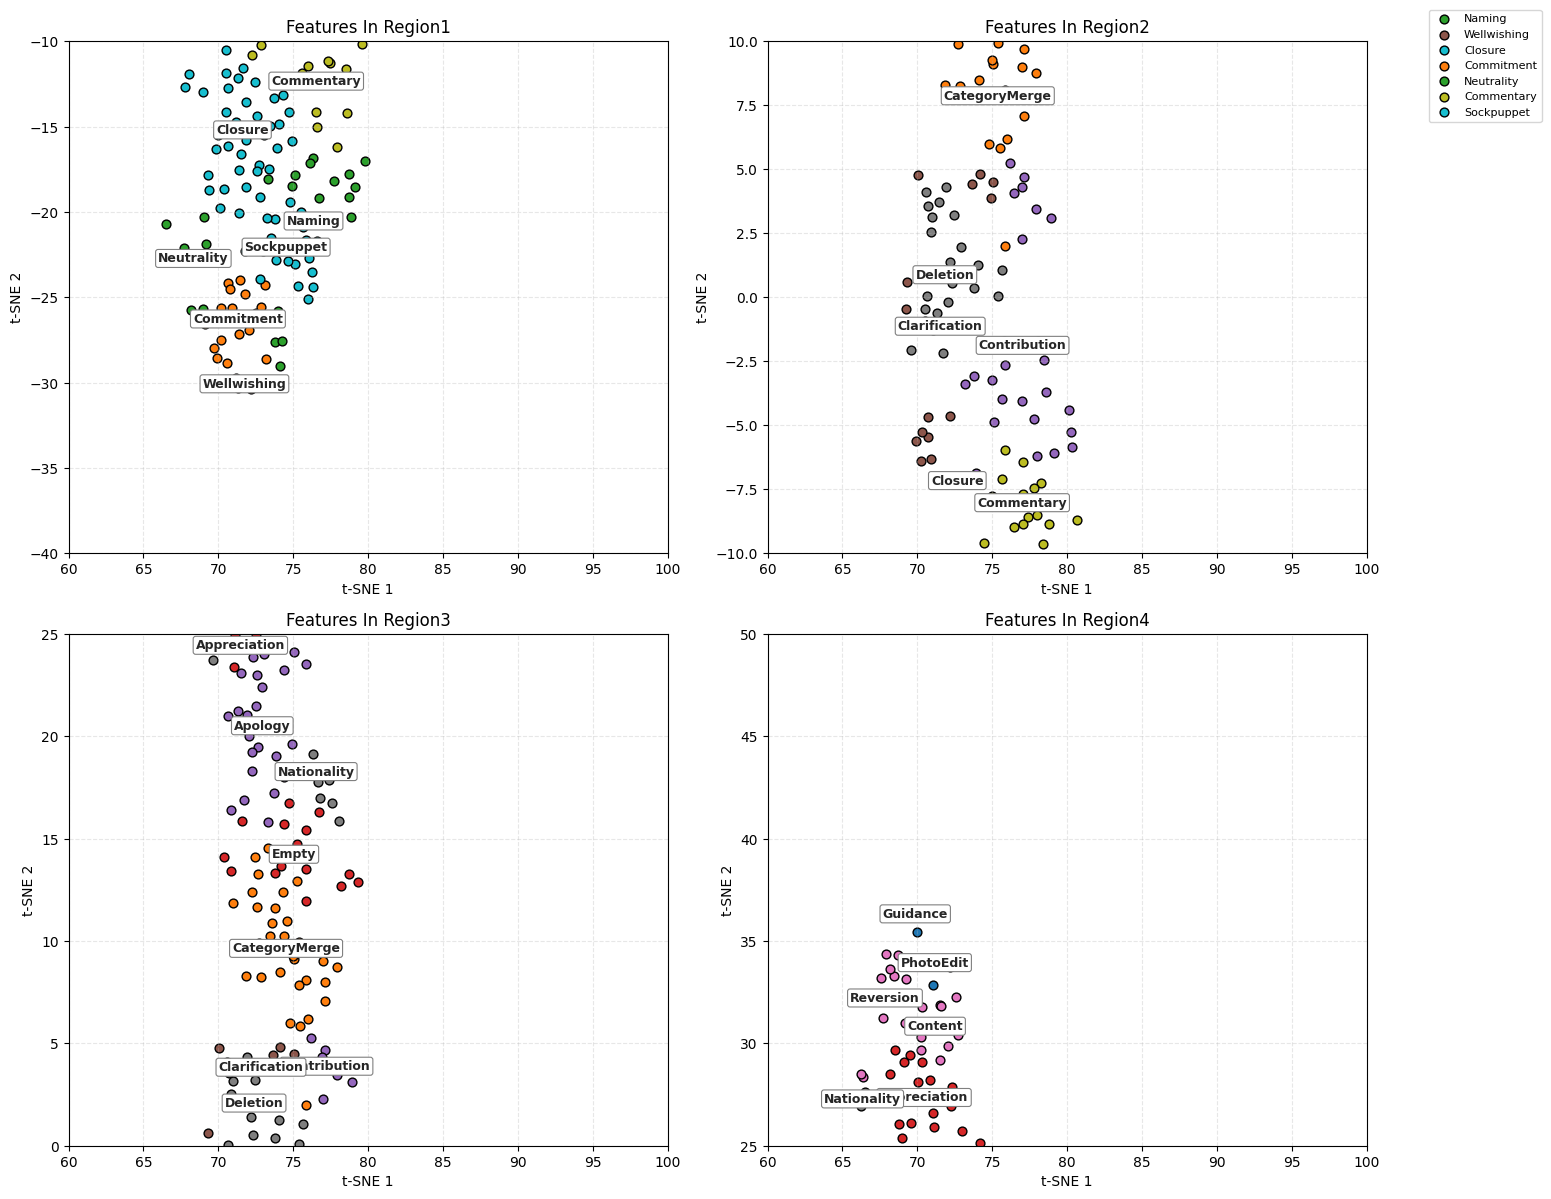

In [196]:
import numpy as np
import matplotlib.pyplot as plt

# Cluster labels mapped to their one-word names
cluster_names = {
    0: "Adhominem", 1: "CategoryMerge", 2: "Naming", 3: "Appreciation", 4: "Contribution",
    5: "Wellwishing", 6: "Reversion", 7: "Nationality", 8: "Guidance", 9: "Closure",
    10: "PhotoEdit", 11: "Commitment", 12: "Neutrality", 13: "Empty", 14: "Apology",
    15: "Clarification", 16: "Content", 17: "Deletion", 18: "Commentary", 19: "Sockpuppet",
}

n_clusters = np.max(utterance_cluster_labels) + 1
cmap = plt.get_cmap('tab10')
colors = [cmap(i % 10) for i in range(n_clusters)]

# Adjusted vertical zoom windows on the right (x ∈ [60, 100])
zoom_regions = [
    (60, 100, -40, -10),
    (60, 100, -10, 10),
    (60, 100, 0, 25),
    (60, 100, 25, 50),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for k, ax in enumerate(axes):
    x_min, x_max, y_min, y_max = zoom_regions[k]

    for c in range(n_clusters):
        idx = np.where(utterance_cluster_labels == c)[0]
        points = Z[idx]

        # Filter points inside zoom region
        mask = (x_min <= points[:, 0]) & (points[:, 0] <= x_max) & \
               (y_min <= points[:, 1]) & (points[:, 1] <= y_max)
        zoom_points = points[mask]

        if zoom_points.size == 0:
            continue

        ax.scatter(zoom_points[:, 0], zoom_points[:, 1],
                   s=40, color=colors[c],
                   label=cluster_names.get(c, f"Cluster {c}"),
                   edgecolor='k')

        centroid_x, centroid_y = np.mean(zoom_points, axis=0)
        ax.text(centroid_x, centroid_y, cluster_names.get(c, f"C-{c}"),
                fontsize=9, fontweight='bold', color='black', alpha=0.85,
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='gray', lw=0.8))

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Features In Region{k+1}")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.grid(True, linestyle='--', alpha=0.3)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

More 


In [237]:
from sklearn.manifold import TSNE
import numpy as np

# Assume utterance_embeddings shape: (5000, 768)
print(f"Embedding shape: {utterance_embeddings.shape}")

tsne = TSNE(n_components=2, perplexity=40, init='pca', random_state=42, n_iter=1000, verbose=1)
Z = tsne.fit_transform(utterance_embeddings)  # (5000, 2)

print(f"t-SNE output shape: {Z.shape}")

Embedding shape: (5000, 768)


/opt/homebrew/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.109s...
[t-SNE] Computed neighbors for 5000 samples in 0.807s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 31.364193
[t-SNE] KL divergence after 1000 iterations: -0.054235
t-SNE output shape: (5000, 2)


In [239]:
print(f"Shape of Z: {Z.shape}")
print(f"Number of cluster labels: {len(utterance_cluster_labels)}")
print(f"Unique clusters and counts:")
import collections
print(collections.Counter(utterance_cluster_labels))

Shape of Z: (5000, 2)
Number of cluster labels: 5000
Unique clusters and counts:
Counter({np.int32(0): 4665, np.int32(9): 38, np.int32(1): 31, np.int32(18): 29, np.int32(4): 26, np.int32(14): 26, np.int32(17): 24, np.int32(3): 23, np.int32(19): 21, np.int32(11): 19, np.int32(2): 16, np.int32(13): 15, np.int32(15): 14, np.int32(16): 13, np.int32(7): 11, np.int32(6): 10, np.int32(12): 8, np.int32(5): 5, np.int32(10): 5, np.int32(8): 1})


In [221]:
from sklearn.metrics import silhouette_score

score = silhouette_score(Z, utterance_cluster_labels)
print(f"Silhouette score: {score:.2f}")

Silhouette score: 0.95


In [223]:
for c in range(n_clusters):
    idx = np.where(utterance_cluster_labels == c)[0]
    representative = utterance_embeddings[idx[:5]]  # or do similarity search
    print(f"\nCluster {c} ({cluster_names.get(c)}):")
    for text in representative:
        print(f" - {text[:80]}")


Cluster 0 (Adhominem):
 - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 

In [227]:
print(f"Length of utterance_texts: {len(utterance_texts)}")
print(f"Length of utterance_cluster_labels: {len(utterance_cluster_labels)}")
print(f"Max index in cluster 18: {indices.max()}")

Length of utterance_texts: 1
Length of utterance_cluster_labels: 5000
Max index in cluster 18: 593


In [235]:
import numpy as np

# Assume X is your embedding tensor of shape (M=768, I=50, J=100)
M, I, J = 768, 50, 100

# Example corpus structure:
# corpus = [
#   conversation_0 = {'utterances': [utt0, utt1, ..., utt49]},
#   conversation_1 = {'utterances': [...]},
#   ...
# ]
# where each utt has attribute 'text'

# Build utterance_texts aligned with X's flattening order: utterances within conversations
utterance_texts = []
for j, conversation in enumerate(corpus.iter_conversations()):
    for utterance in conversation.iter_utterances():
        utterance_texts.append(utterance.text)
    if j + 1 == J:
        break

print(f"Total utterances: {len(utterance_texts)} (should be {I*J})")

# Assume you have:
# utterance_cluster_labels: numpy array of length I*J, cluster ids for each utterance
# cluster_names: dict mapping cluster_id -> name

n_clusters = np.max(utterance_cluster_labels) + 1

for c in range(n_clusters):
    indices = np.where(utterance_cluster_labels == c)[0]
    if len(indices) == 0:
        continue
    representative_texts = [utterance_texts[i] for i in indices[:2]]
    print(f"\nCluster {c} ({cluster_names.get(c, f'Cluster {c}')}):")
    for text in representative_texts:
        print(f" - {text[:80]}")  # print first 80 characters

# Optionally, find most central utterance by recurrence (if you have recurrence_scores aligned similarly):
if 'recurrence_scores' in globals():
    cluster_id = 18
    indices = np.where(utterance_cluster_labels == cluster_id)[0]
    cluster_recurrences = recurrence_scores[indices]
    top_idx = indices[np.argmax(cluster_recurrences)]
    print(f"\nMost central utterance in Cluster {cluster_id} ({cluster_names.get(cluster_id)}):")
    print(utterance_texts[top_idx])

Total utterances: 338 (should be 5000)

Cluster 0 (Adhominem):
 - Capricornis, stop insinuating. And please refrain from various [[Ad hominem]] ar
 - Glad that you got my point. Actually Sreekarakkineni, Niranjaniyengar and this I

Cluster 1 (CategoryMerge):
 - Yes, that's good. Revathy's page looked very reliable, that's why we used that a
 - My apologies, I forgot to include the disambiguator. Please check now - it shoul

Cluster 2 (Naming):
 - Licensing isn't quite right. I've dropped a note on the editor's talk; won't rem
 - I had no idea! I just reverted the edit because he stated that the subject was a

Cluster 3 (Appreciation):
 - I don't understand what you are saying. Could you please be more precise? 
 - You must have misunderstood something? I was commenting on your contributions, n

Cluster 4 (Contribution):
 - You should look at all of the point on the template not just the last one, the t
 - Yes I agree. The law permits usage of documents, photographs and other materials


Clusters group utterances by content/type; rooms provide the context. Studying their interaction reveals how conversation styles or topics distribute across different social or topical settings.

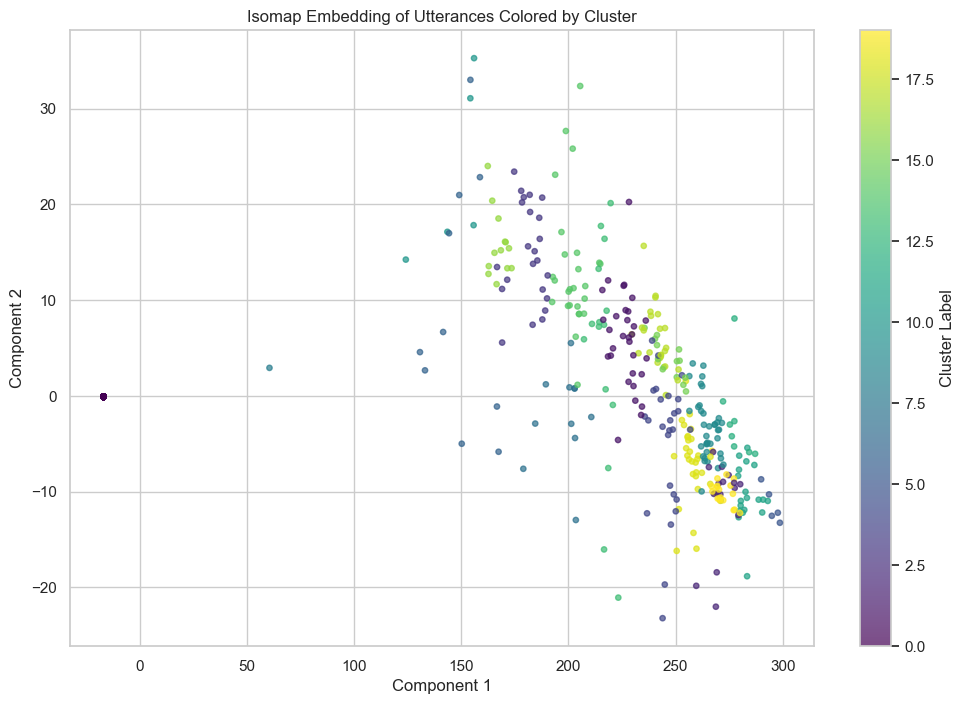

In [ ]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

reducer = Isomap(n_neighbors=30, n_components=2)
Z_isomap = reducer.fit_transform(utterance_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(Z_isomap[:, 0], Z_isomap[:, 1], c=utterance_cluster_labels, cmap='viridis', s=15, alpha=0.9)
plt.colorbar(label='Cluster Label')
plt.title("Isomap Embedding of Utterances Colored by Cluster")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

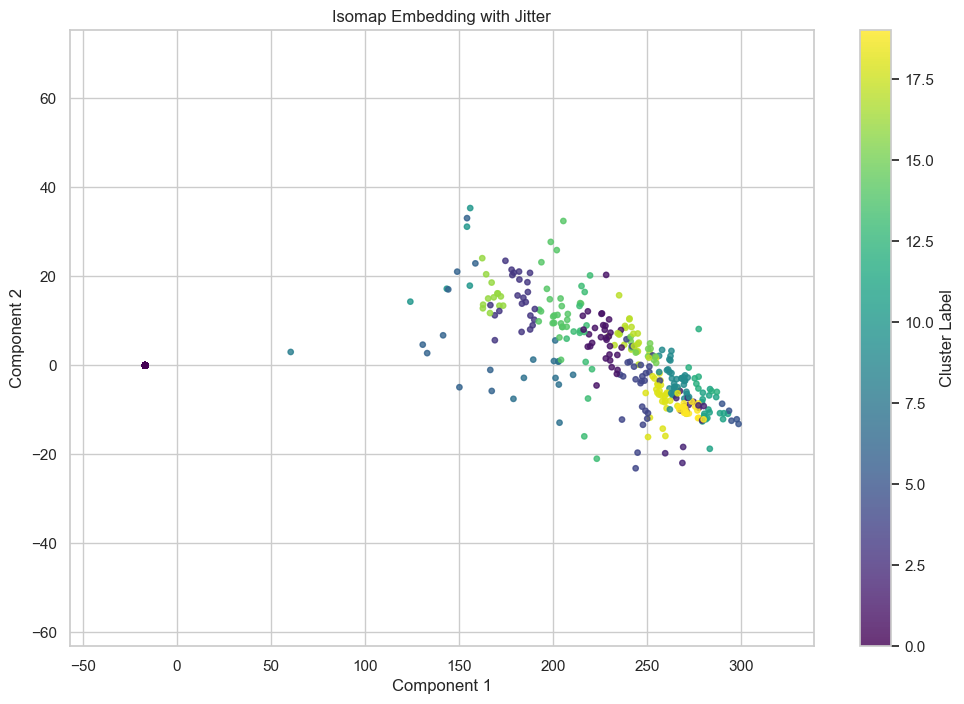

In [274]:
import numpy as np

jitter_scale = 1e-3
Z_jittered = Z_isomap + np.random.normal(scale=jitter_scale, size=Z_isomap.shape)

plt.figure(figsize=(12, 8))
plt.scatter(Z_jittered[:, 0], Z_jittered[:, 1], c=utterance_cluster_labels, cmap='viridis', s=15, alpha=0.8)
plt.colorbar(label='Cluster Label')
plt.title("Isomap Embedding with Jitter")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.xlim(min(x) - 40, max(x) + 40)
plt.ylim(min(y) - 40, max(y) + 40)
plt.grid(True)
plt.show()

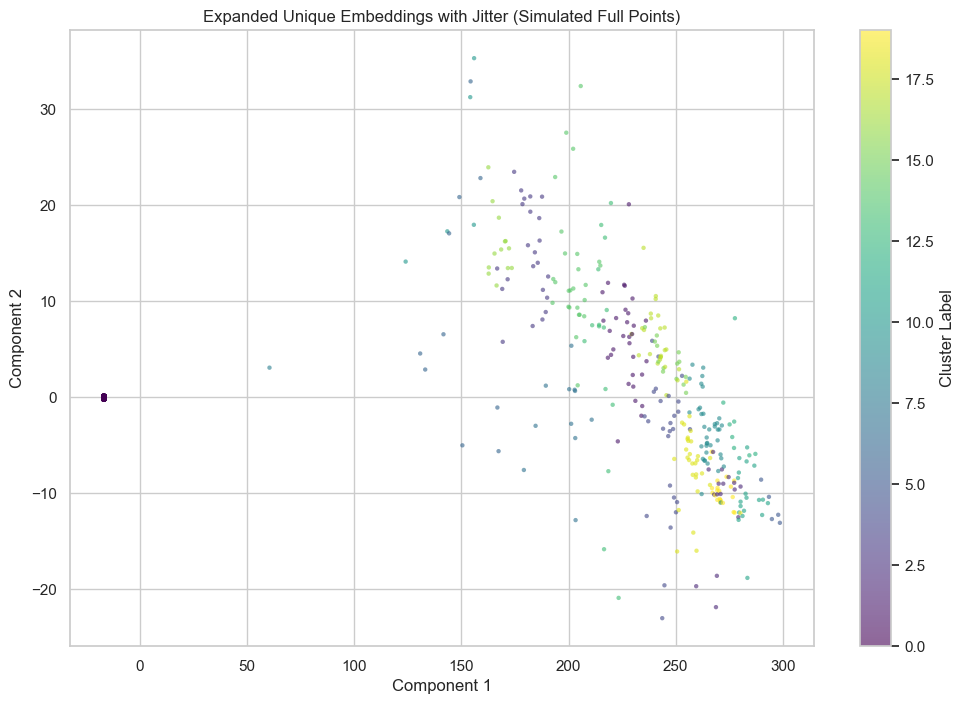

In [282]:
import numpy as np
import matplotlib.pyplot as plt

# Example: counts DataFrame with ['x', 'y', 'cluster', 'count']

jitter_strength = 0.2  # small noise magnitude
points_x = []
points_y = []
points_cluster = []

for _, row in counts.iterrows():
    n = int(row['count'])  # how many identical points
    # Generate jittered points around the cluster center
    jitter_x = row['x'] + np.random.uniform(-jitter_strength, jitter_strength, size=n)
    jitter_y = row['y'] + np.random.uniform(-jitter_strength, jitter_strength, size=n)
    points_x.extend(jitter_x)
    points_y.extend(jitter_y)
    points_cluster.extend([row['cluster']] * n)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(points_x, points_y, c=points_cluster, cmap='viridis', s=10, alpha=0.6, edgecolor='none')

plt.colorbar(scatter, label='Cluster Label')
plt.title("Expanded Unique Embeddings with Jitter (Simulated Full Points)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

In [255]:
from collections import Counter

counts = Counter(utterance_cluster_labels)
print("Points per cluster:")
for c in sorted(counts):
    name = cluster_names.get(c, f"Cluster {c}")
    print(f"  Cluster {c} ({name}): {counts[c]}")
print(f"Total points: {sum(counts.values())}")

Points per cluster:
  Cluster 0 (Adhominem): 4665
  Cluster 1 (CategoryMerge): 31
  Cluster 2 (Naming): 16
  Cluster 3 (Appreciation): 23
  Cluster 4 (Contribution): 26
  Cluster 5 (Wellwishing): 5
  Cluster 6 (Reversion): 10
  Cluster 7 (Nationality): 11
  Cluster 8 (Guidance): 1
  Cluster 9 (Closure): 38
  Cluster 10 (PhotoEdit): 5
  Cluster 11 (Commitment): 19
  Cluster 12 (Neutrality): 8
  Cluster 13 (Empty): 15
  Cluster 14 (Apology): 26
  Cluster 15 (Clarification): 14
  Cluster 16 (Content): 13
  Cluster 17 (Deletion): 24
  Cluster 18 (Commentary): 29
  Cluster 19 (Sockpuppet): 21
Total points: 5000


Beeswarm


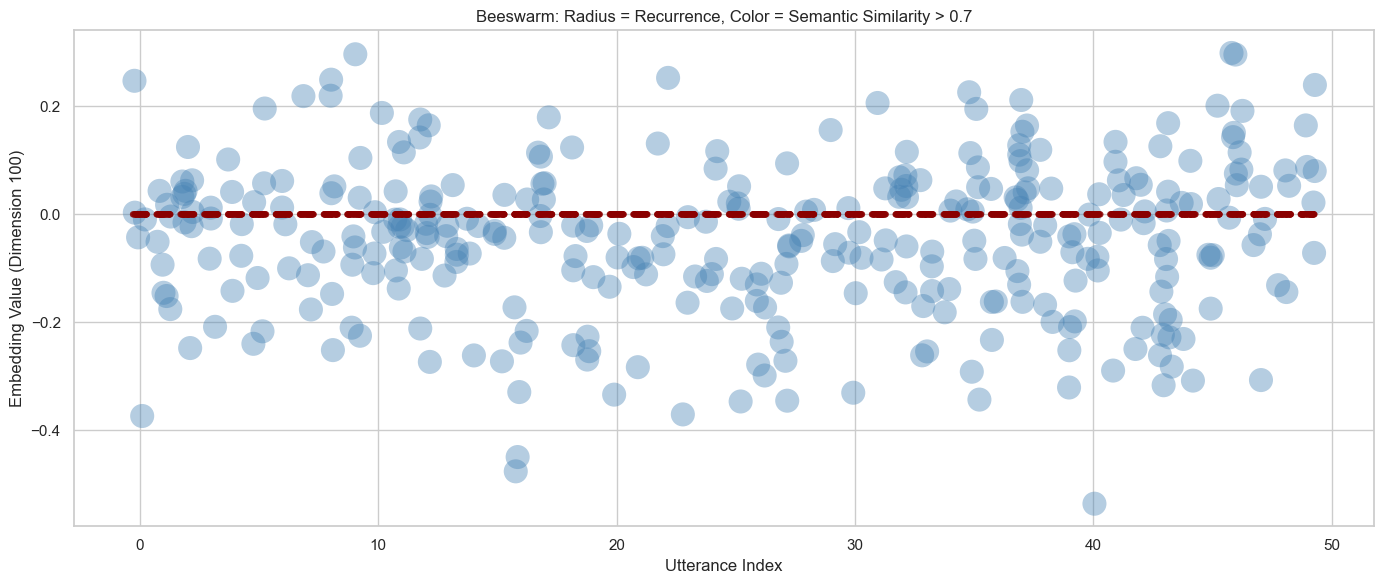

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# === Step 1: Prepare utterance embeddings from tensor X ===
# Assume X is of shape (768, I, J) where:
#   - 768 = embedding dimension
#   - I = utterances per conversation
#   - J = number of conversations

M, I, J = X.shape
N = I * J  # total number of utterances

# Reshape to (N, 768)
utterance_embeddings = X.reshape(M, N).T  # (N, 768)

# === Step 2: Sanitize and compute cosine similarity ===
utterance_embeddings = np.nan_to_num(utterance_embeddings, nan=0.0, posinf=1e5, neginf=-1e5)
utterance_embeddings = np.clip(utterance_embeddings, -1e3, 1e3)

similarity_matrix = cosine_similarity(utterance_embeddings)
np.fill_diagonal(similarity_matrix, 0)  # remove self-similarity

# === Step 3: Compute recurrence and binary labels ===
threshold = 0.5
recurrence_scores = (similarity_matrix > threshold).sum(axis=1)  # recurrence count per utterance
binary_similarity = (recurrence_scores > 0).astype(int)  # binary: has at least one match

# === Step 4: Normalize recurrence for radius ===
scaler = MinMaxScaler(feature_range=(20, 300))
radius_scaled = scaler.fit_transform(recurrence_scores.reshape(-1, 1)).flatten()

# === Step 5: Beeswarm-style plot ===
dim = 100  # example embedding dimension to visualize
values = X[dim].reshape(-1)               # shape: (N,)
utterance_idx = np.tile(np.arange(I), J)  # shape: (N,)
x_jittered = utterance_idx + np.random.uniform(-0.3, 0.3, size=N)
colors = np.where(binary_similarity == 1, 'steelblue', 'darkred')

plt.figure(figsize=(14, 6))
plt.scatter(x_jittered, values, s=radius_scaled, c=colors, alpha=0.4, linewidth=0)
plt.xlabel("Utterance Index")
plt.ylabel(f"Embedding Value (Dimension {dim})")
plt.title("Beeswarm: Radius = Recurrence, Color = Semantic Similarity > 0.7")
plt.grid(True)
plt.tight_layout()
plt.show()

# === (Optional) Step 6: Cluster utterances into pseudo-rooms ===
k = 12
cluster_labels = KMeans(n_clusters=k, random_state=42).fit_predict(utterance_embeddings)